# Data Preparation

## Introduction

This notebook demonstrates how to prepare the [SIIM-ISIC Melanoma Classification](https://challenge2020.isic-archive.com/) dataset for fine-tuning multimodal AI models using Axolotl. 

The SIIM-ISIC dataset contains over 33,000 dermoscopic images of skin lesions with corresponding labels indicating whether each lesion is benign or malignant melanoma. The dataset was released as part of the ISIC 2020 Challenge to help improve melanoma detection algorithms. Each image comes with additional metadata including the patient's age, sex, and the anatomical site of the lesion.

Our goal is to transform this raw medical imaging dataset into the specific format required by Axolotl for multimodal fine-tuning. This involves:

1. Downloading and exploring the dataset
2. Splitting the data into training, validation, and test sets while maintaining class distribution
3. Processing the images and labels into the chat template format required by Axolotl
4. Creating properly formatted JSONL files that maintain the relationship between images and their diagnoses

The output will be a training-ready dataset that follows Axolotl's multimodal specification for fine-tuning Gemma 3 on this melanoma classification task.

**Note**: The complete data preparation process may take approximately 30-40 minutes, primarily due to the download and extraction of the 32GB image archive.

## Install dependencies

Let's start by installing the required packages:

In [2]:
!pip install google-cloud-storage -q
!pip install numpy==1.26.4 -q

## Set up your environment

In [ ]:
# If you're running this in Google Colab or Vertex AI Workbench, make sure you're 
# authenticated with Google Cloud:
# !gcloud auth login
# !gcloud config set project YOUR_PROJECT_ID

## Import libraries and set up configuration

In [3]:
import json
import os
import shutil
import tempfile
import warnings
import zipfile
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import logging

# Third-party imports
from google.cloud import storage
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore", category=FutureWarning)

# Configuration
SOURCE_BUCKET = "axolotl-multimodal-tuning-isic-2020-dataset" # Replace with your bucket
DEST_BUCKET = "axolotl-multimodal-tuning-isic-2020-dataset" # Replace with your bucket
SOURCE_FOLDER = "isic-challenge-data.s3.amazonaws.com/2020"
DEST_FOLDER = "axolotl-data"

# Initialize Cloud Storage client
client = storage.Client()
source_bucket = client.bucket(SOURCE_BUCKET)
dest_bucket = client.bucket(DEST_BUCKET)

# Create temp directories
os.makedirs("/tmp/train_images", exist_ok=True)

# Set thread pool parameters
MAX_WORKERS = 16  # Adjust based on your system's capabilities

## List all files in the dataset

In [4]:
files = list(source_bucket.list_blobs(prefix=SOURCE_FOLDER))
for file in files:
    print(file.name)

isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Test_JPEG.zip
isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Test_Metadata.csv
isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_GroundTruth.csv
isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_GroundTruth_v2.csv
isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_JPEG.zip


## Download, explore, and visualize the dataset


Dataset Overview:
Total samples: 33126


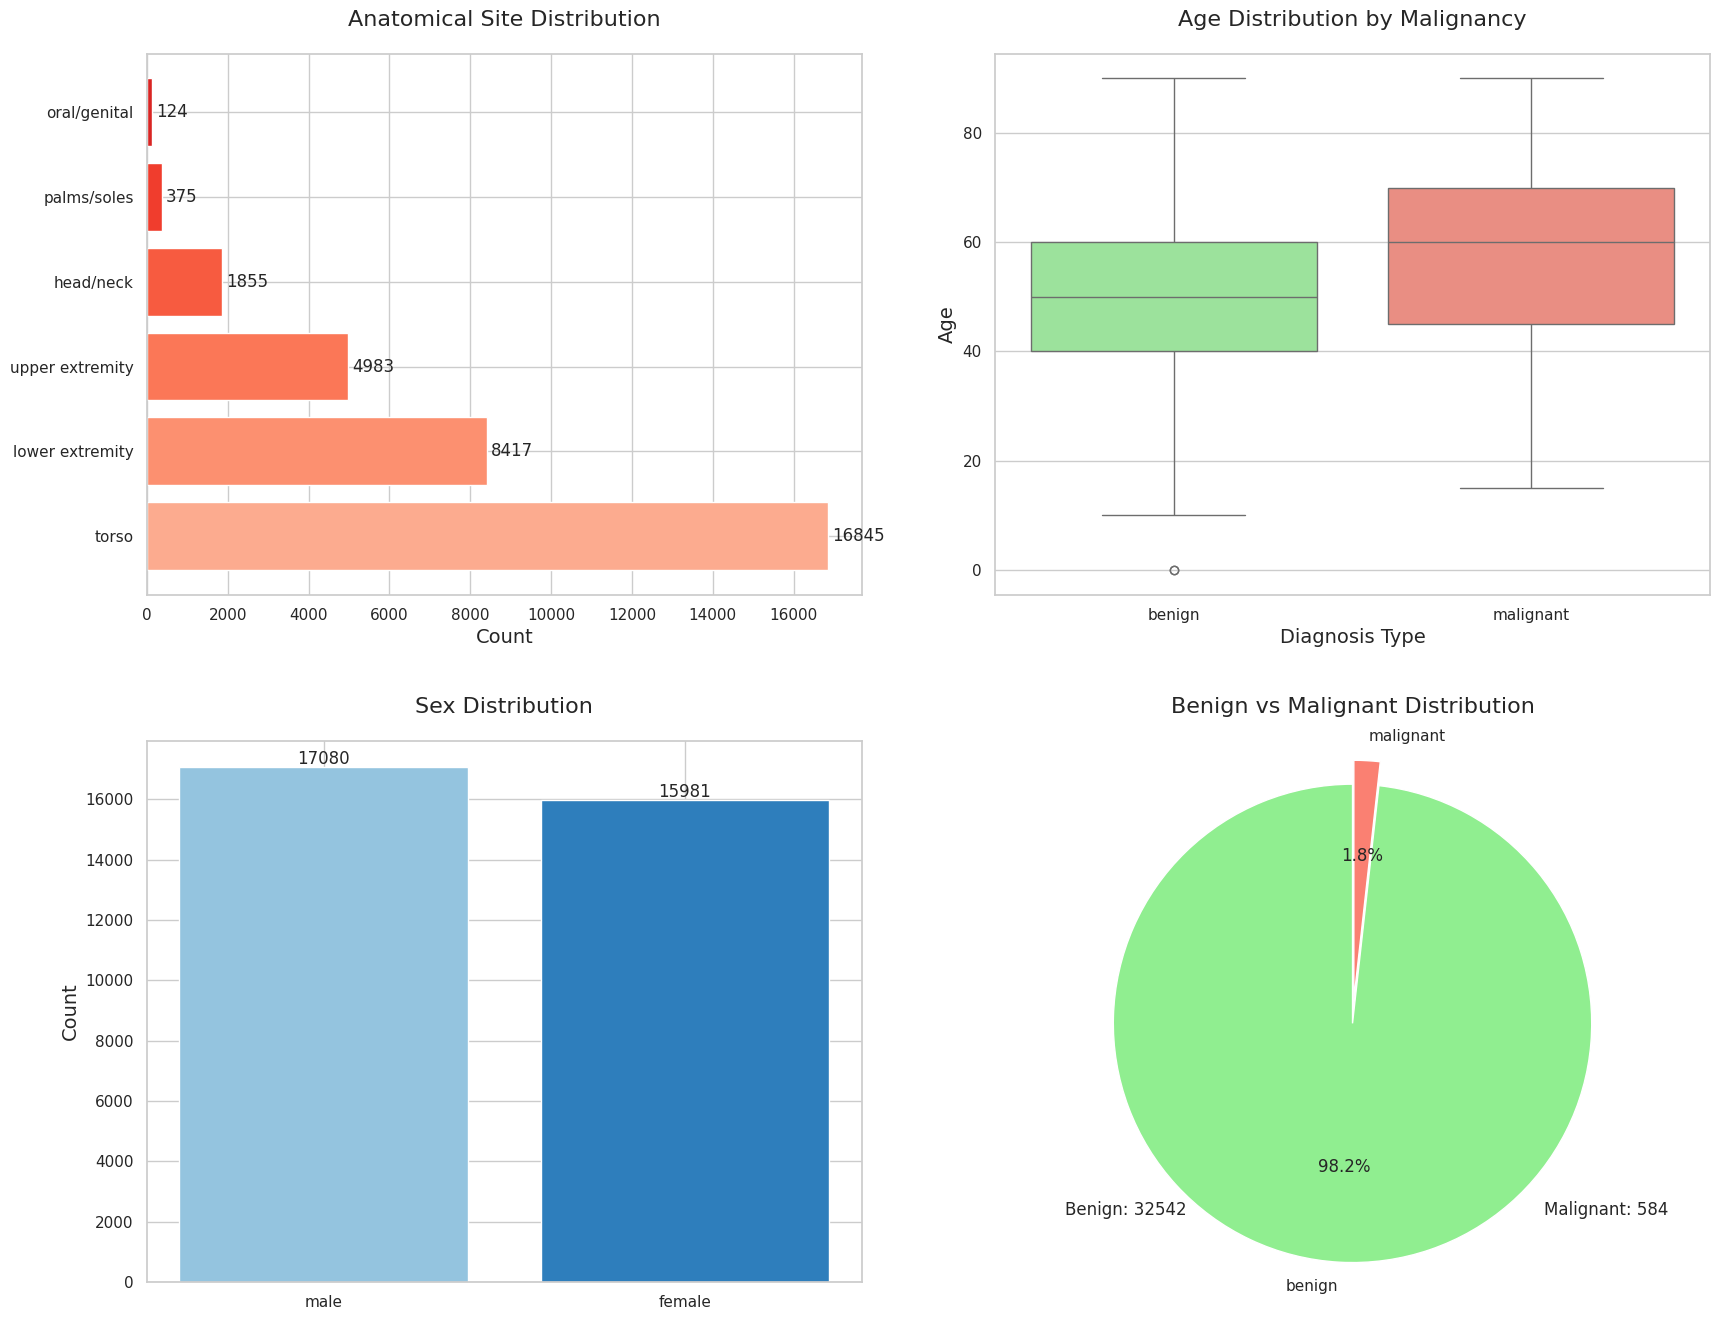

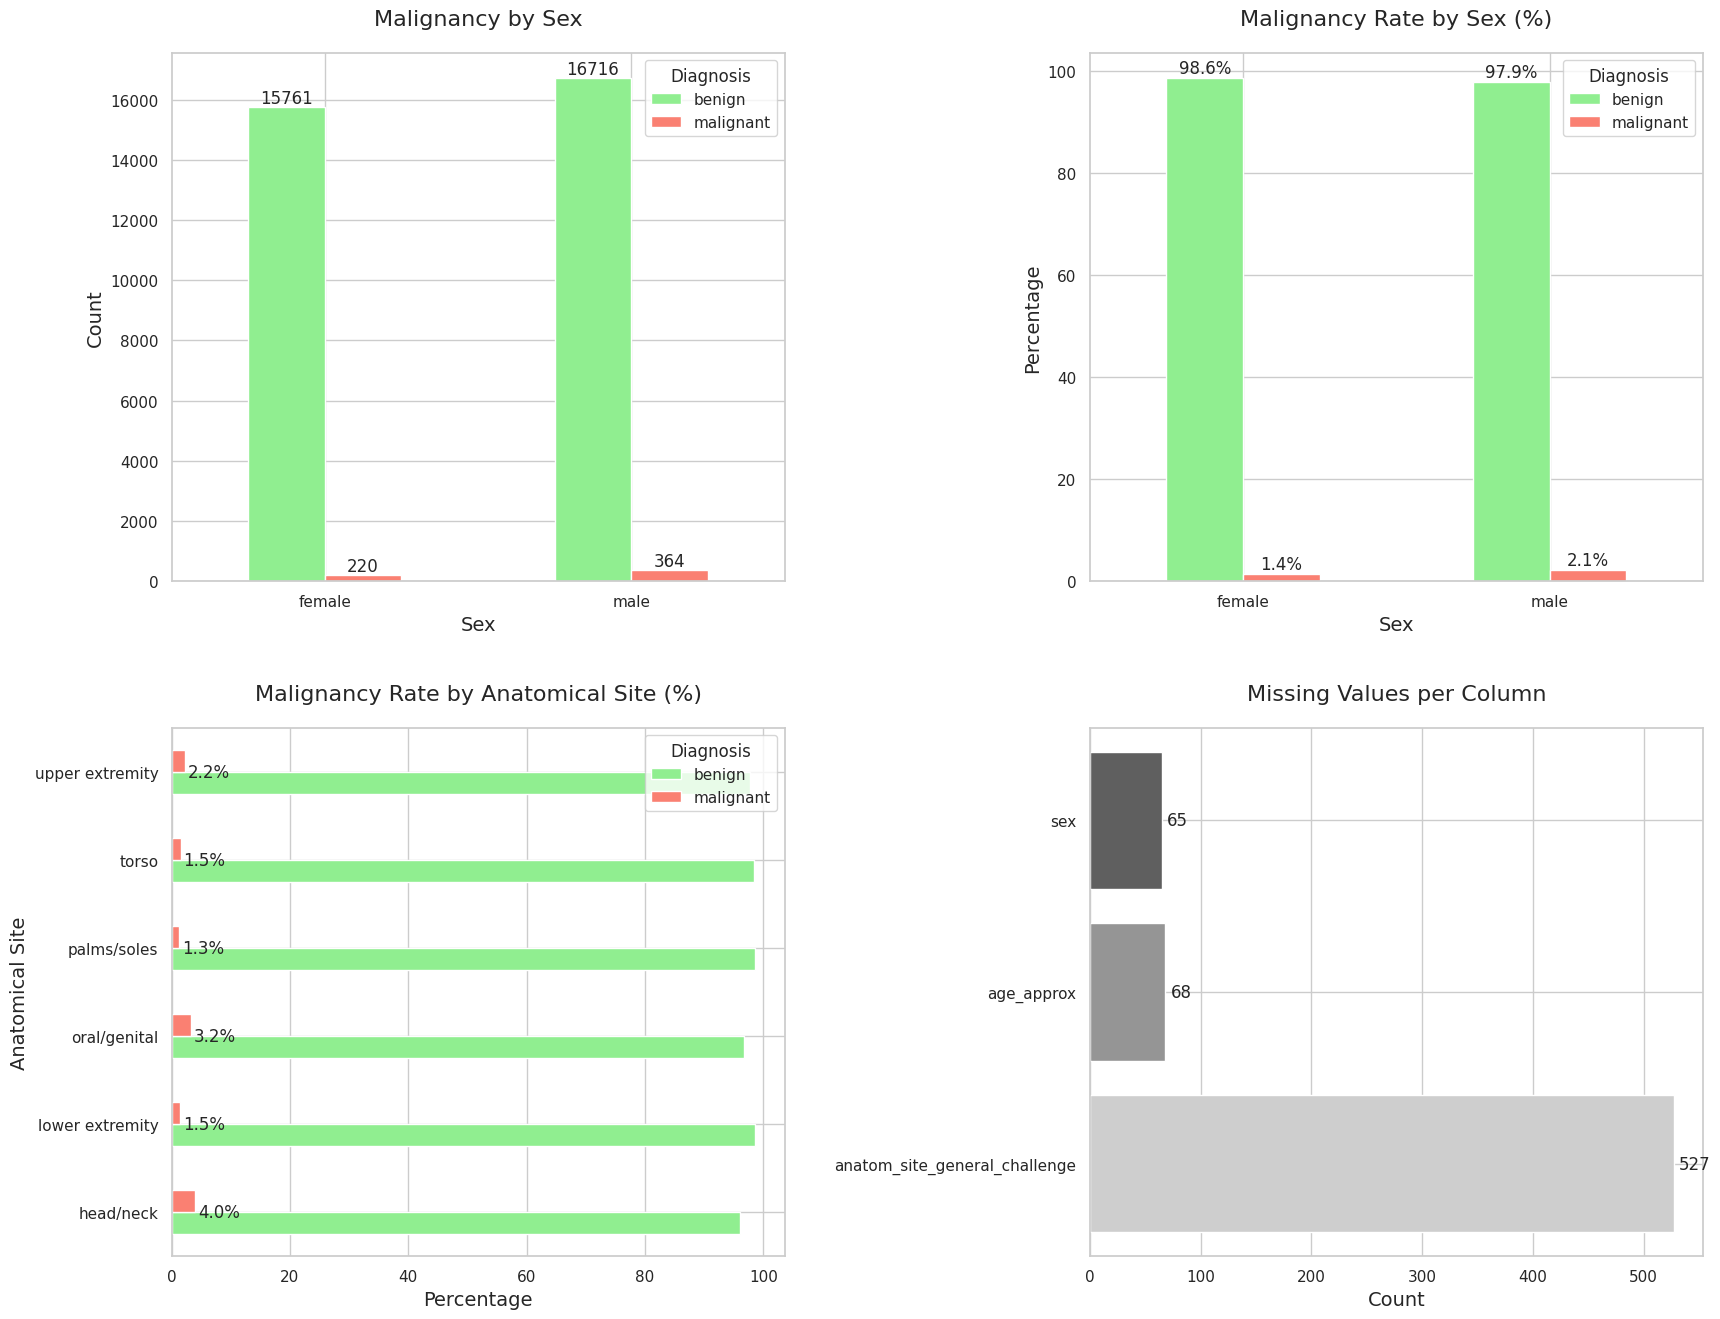

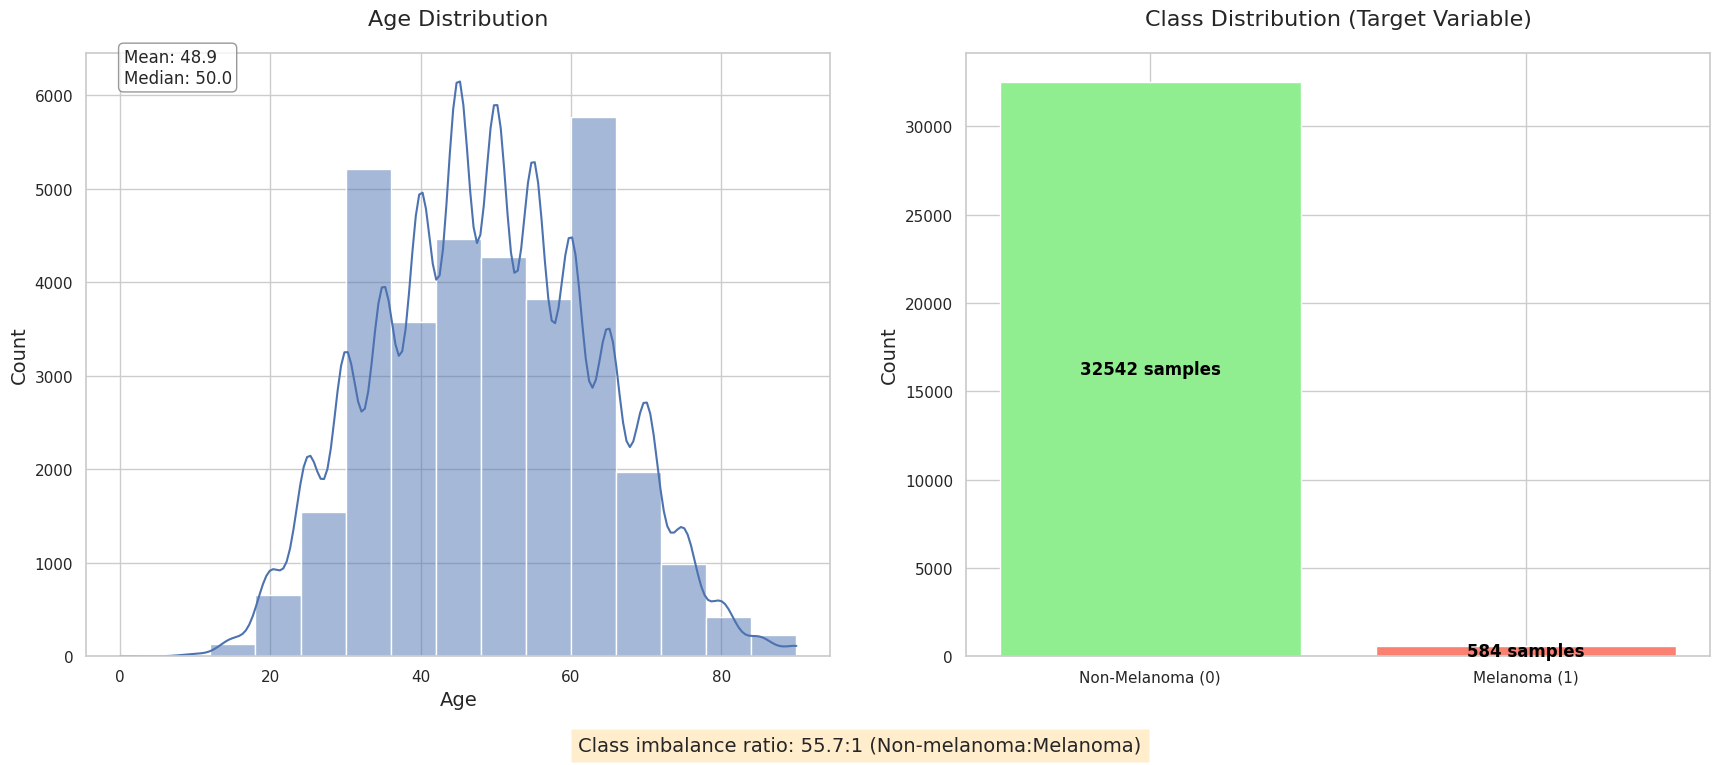


Diagnosis distribution:
diagnosis
unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
cafe-au-lait macule                       1
atypical melanocytic proliferation        1
Name: count, dtype: int64

Benign/Malignant distribution:
benign_malignant
benign       32542
malignant      584
Name: count, dtype: int64

Missing values per column:
image_name                         0
patient_id                         0
lesion_id                          0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64

Class imbalance ratio (Benign:Malignant): 55.72:1


In [5]:
# Download metadata CSV and examine structure
metadata_blob = source_bucket.blob(f"{SOURCE_FOLDER}/ISIC_2020_Training_GroundTruth_v2.csv")
with tempfile.NamedTemporaryFile() as temp_file:
    metadata_blob.download_to_filename(temp_file.name)
    train_metadata = pd.read_csv(temp_file.name)
    
    # Print dataset statistics
    print("\nDataset Overview:")
    print(f"Total samples: {len(train_metadata)}")
    
    # Set plot style
    sns.set(style="whitegrid")
    plt.rcParams.update({'font.size': 12})
    
    # Figure 1: Key Distributions
    plt.figure(figsize=(18, 14))
    
    # 1. Anatomical Site Distribution
    plt.subplot(2, 2, 1)
    site_counts = train_metadata['anatom_site_general_challenge'].value_counts()
    ax = plt.barh(site_counts.index, site_counts.values, color=plt.cm.Reds(np.linspace(0.3, 0.7, len(site_counts))))
    plt.title('Anatomical Site Distribution', fontsize=16, pad=20)
    plt.xlabel('Count', fontsize=14)
    
    # Add count labels to bars
    for i, v in enumerate(site_counts.values):
        plt.text(v + 100, i, str(v), va='center')
    
    # 2. Age Distribution by Malignancy
    plt.subplot(2, 2, 2)
    ax = sns.boxplot(x='benign_malignant', y='age_approx', data=train_metadata, 
                     palette={'benign': 'lightgreen', 'malignant': 'salmon'})
    plt.title('Age Distribution by Malignancy', fontsize=16, pad=20)
    plt.xlabel('Diagnosis Type', fontsize=14)
    plt.ylabel('Age', fontsize=14)
    
    # 3. Sex Distribution
    plt.subplot(2, 2, 3)
    sex_counts = train_metadata['sex'].value_counts()
    ax = plt.bar(sex_counts.index, sex_counts.values, color=plt.cm.Blues(np.linspace(0.4, 0.7, len(sex_counts))))
    plt.title('Sex Distribution', fontsize=16, pad=20)
    plt.ylabel('Count', fontsize=14)
    
    # Add count labels to bars
    for i, v in enumerate(sex_counts.values):
        plt.text(i, v + 100, str(v), ha='center')
    
    # 4. Benign vs Malignant Distribution
    plt.subplot(2, 2, 4)
    diagnosis_counts = train_metadata['benign_malignant'].value_counts()
    plt.pie(diagnosis_counts, labels=diagnosis_counts.index, autopct='%1.1f%%', 
            colors=['lightgreen', 'salmon'], startangle=90, explode=(0, 0.1))
    plt.title('Benign vs Malignant Distribution', fontsize=16, pad=20)
    plt.axis('equal')
    
    # Add text annotations with counts
    plt.annotate(f"Benign: {diagnosis_counts['benign']}", xy=(-1.2, -0.8), fontsize=12)
    plt.annotate(f"Malignant: {diagnosis_counts['malignant']}", xy=(0.8, -0.8), fontsize=12)
    
    plt.tight_layout(pad=3.0)
    plt.show()
    
    # Figure 2: Relationships between variables
    plt.figure(figsize=(18, 14))
    
    # 1. Malignancy by Sex
    plt.subplot(2, 2, 1)
    sex_malig = pd.crosstab(train_metadata['sex'], train_metadata['benign_malignant'])
    ax = sex_malig.plot(kind='bar', color=['lightgreen', 'salmon'], ax=plt.gca())
    plt.title('Malignancy by Sex', fontsize=16, pad=20)
    plt.ylabel('Count', fontsize=14)
    plt.xlabel('Sex', fontsize=14)
    plt.xticks(rotation=0)
    plt.legend(title='Diagnosis')
    
    # Add text labels
    for p in ax.patches:
        ax.annotate(str(int(p.get_height())), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'bottom')
    
    # 2. Malignancy Rate by Sex
    plt.subplot(2, 2, 2)
    sex_malig_rate = pd.crosstab(train_metadata['sex'], 
                               train_metadata['benign_malignant'], 
                               normalize='index') * 100
    ax = sex_malig_rate.plot(kind='bar', color=['lightgreen', 'salmon'], ax=plt.gca())
    plt.title('Malignancy Rate by Sex (%)', fontsize=16, pad=20)
    plt.ylabel('Percentage', fontsize=14)
    plt.xlabel('Sex', fontsize=14)
    plt.xticks(rotation=0)
    plt.legend(title='Diagnosis')
    
    # Add text labels
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%", 
                   (p.get_x() + p.get_width() / 2., p.get_height() + 1), 
                   ha = 'center')
    
    # 3. Malignancy Rate by Anatomical Site
    plt.subplot(2, 2, 3)
    # Filter out any NaN values and ensure proper calculation
    site_data = train_metadata.dropna(subset=['anatom_site_general_challenge'])
    site_malig = pd.crosstab(site_data['anatom_site_general_challenge'], 
                           site_data['benign_malignant'], 
                           normalize='index') * 100
    ax = site_malig.plot(kind='barh', color=['lightgreen', 'salmon'], ax=plt.gca())
    plt.title('Malignancy Rate by Anatomical Site (%)', fontsize=16, pad=20)
    plt.xlabel('Percentage', fontsize=14)
    plt.ylabel('Anatomical Site', fontsize=14)
    plt.legend(title='Diagnosis')
    
    # Add percentage labels for malignant cases
    for i, v in enumerate(site_malig['malignant']):
        plt.text(v + 0.5, i, f"{v:.1f}%", va='center')
    
    # 4. Missing Values Visualization
    plt.subplot(2, 2, 4)
    missing_values = train_metadata.isnull().sum().sort_values(ascending=False)
    # Only show columns with missing values
    missing_values = missing_values[missing_values > 0]
    if len(missing_values) > 0:
        ax = plt.barh(missing_values.index, missing_values.values, 
                     color=plt.cm.Greys(np.linspace(0.3, 0.7, len(missing_values))))
        plt.title('Missing Values per Column', fontsize=16, pad=20)
        plt.xlabel('Count', fontsize=14)
        
        # Add count labels to bars
        for i, v in enumerate(missing_values.values):
            plt.text(v + 5, i, str(v), va='center')
    else:
        plt.text(0.5, 0.5, "No missing values!", ha='center', va='center', fontsize=14)
        plt.title('Missing Values Check', fontsize=16, pad=20)
        plt.axis('off')
    
    plt.tight_layout(pad=3.0)
    plt.show()
    
    # Figure 3: Additional visualizations
    plt.figure(figsize=(18, 8))
    
    # 1. Age distribution
    plt.subplot(1, 2, 1)
    ax = sns.histplot(train_metadata['age_approx'].dropna(), bins=15, kde=True)
    plt.title('Age Distribution', fontsize=16, pad=20)
    plt.xlabel('Age', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    
    # Add statistics annotation
    age_mean = train_metadata['age_approx'].mean()
    age_median = train_metadata['age_approx'].median()
    plt.annotate(f"Mean: {age_mean:.1f}\nMedian: {age_median:.1f}", 
                xy=(0.05, 0.95), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    # 2. Class imbalance (target variable)
    plt.subplot(1, 2, 2)
    target_counts = train_metadata['target'].value_counts()
    ax = plt.bar(['Non-Melanoma (0)', 'Melanoma (1)'], target_counts.values, 
               color=['lightgreen', 'salmon'])
    plt.text(0, target_counts[0]/2, f"{target_counts[0]} samples", 
           ha='center', va='center', color='black', fontweight='bold')
    plt.text(1, target_counts[1]/2, f"{target_counts[1]} samples", 
           ha='center', va='center', color='black', fontweight='bold')
    plt.title('Class Distribution (Target Variable)', fontsize=16, pad=20)
    plt.ylabel('Count', fontsize=14)
    
    # Add imbalance ratio annotation
    imbalance_ratio = target_counts[0] / target_counts[1]
    plt.figtext(0.5, 0.01, f"Class imbalance ratio: {imbalance_ratio:.1f}:1 (Non-melanoma:Melanoma)", 
              ha='center', fontsize=14, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
    
    plt.tight_layout(pad=3.0)
    plt.show()
    
    # Print additional textual information
    print("\nDiagnosis distribution:")
    print(train_metadata['diagnosis'].value_counts())
    
    print("\nBenign/Malignant distribution:")
    print(train_metadata['benign_malignant'].value_counts())
    
    # Check for missing values
    print("\nMissing values per column:")
    print(train_metadata.isnull().sum())
    
    # Class imbalance ratio
    imbalance_ratio = len(train_metadata[train_metadata['target'] == 0]) / len(train_metadata[train_metadata['target'] == 1])
    print(f"\nClass imbalance ratio (Benign:Malignant): {imbalance_ratio:.2f}:1")

## Download and extract the image data

In [ ]:
print("Downloading training images ZIP...")
train_zip_blob = source_bucket.blob(f"{SOURCE_FOLDER}/ISIC_2020_Training_JPEG.zip")
with tempfile.NamedTemporaryFile(suffix=".zip") as temp_zip:
    train_zip_blob.download_to_filename(temp_zip.name)
    print("Extracting training images...")
    with zipfile.ZipFile(temp_zip.name, 'r') as zip_ref:
        zip_ref.extractall("/tmp/train_images")

# Count the number of image files extracted
image_count = len(os.listdir("/tmp/train_images"))
print(f"Extracted {image_count} images to temporary directory")

## Split data into train, validation, and test sets (80/10/10)

In [6]:
# First split: 80% train, 20% temp
train_df, temp_df = train_test_split(
    train_metadata, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_metadata['target']
)

# Second split: Split the temp set into validation and test (50/50)
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    random_state=42, 
    stratify=temp_df['target']
)

print(f"Training examples: {len(train_df)}, Validation examples: {len(val_df)}, Test examples: {len(test_df)}")

# Verify class distribution in each split
print("\nClass distribution (target=1 is melanoma):")
print(f"Training set: {train_df['target'].value_counts()}")
print(f"Validation set: {val_df['target'].value_counts()}")
print(f"Test set: {test_df['target'].value_counts()}")

Training examples: 26500, Validation examples: 3313, Test examples: 3313

Class distribution (target=1 is melanoma):
Training set: target
0    26033
1      467
Name: count, dtype: int64
Validation set: target
0    3254
1      59
Name: count, dtype: int64
Test set: target
0    3255
1      58
Name: count, dtype: int64


## Define dataset creation functions

In [7]:
def process_single_example(row, split_name, dataset_type=None, include_metadata=False):
    """
    Process a single example from the dataset
    
    Args:
        row: Pandas DataFrame row with the data for this example
        split_name: String indicating the split type (train, val, test)
        dataset_type: String indicating the dataset type folder prefix (optional)
        include_metadata: Boolean indicating whether to include metadata
        
    Returns:
        Processed example in Axolotl's multimodal format
    """
    image_name = f"{row['image_name']}.jpg"
    
    # For GCS FUSE mounting, paths should not include the bucket name (since the bucket becomes the mount point)
    if dataset_type:
        # Path used in the Axolotl input (for GCS FUSE mounting)
        image_path = f"/mnt/gcs/processed_images/{dataset_type}/{split_name}/{image_name}"
        # Path used for uploading to GCS (includes the bucket)
        upload_path = f"processed_images/{dataset_type}/{split_name}/{image_name}"
    else:
        # Path used in the Axolotl input (for GCS FUSE mounting)
        image_path = f"/mnt/gcs/processed_images/{split_name}/{image_name}"
        # Path used for uploading to GCS (includes the bucket)
        upload_path = f"processed_images/{split_name}/{image_name}"
    
    # Upload image to processed_images folder
    image_local_path = f"/tmp/train_images/train/{image_name}"
    if os.path.exists(image_local_path):
        dest_blob = dest_bucket.blob(upload_path)
        try:
            dest_blob.upload_from_filename(image_local_path)
        except Exception as e:
            print(f"Failed to upload {image_name}: {str(e)}")
    
    is_malignant = row['target'] == 1
    
    # Prepare the user prompt based on whether we include metadata
    if include_metadata:
        # Get metadata values (with error handling for missing or NaN values)
        sex = row['sex'] if pd.notna(row['sex']) else "unknown"
        age = row['age_approx'] if pd.notna(row['age_approx']) else "unknown"
        site = row['anatom_site_general_challenge'] if pd.notna(row['anatom_site_general_challenge']) else "unknown"
        
        user_text = f"This is a skin lesion from a {sex} patient, age {age}, located on the {site}. Does this appear to be malignant melanoma?"
    else:
        user_text = "Does this skin lesion appear to be malignant melanoma?"
    
    # Create the example in Axolotl's multimodal format
    example = {
        "messages": [
            {
                "role": "system",
                "content": [
                    {"type": "text", "text": "You are a dermatology assistant that helps identify potential melanoma from skin lesion images."}
                ]
            },
            {
                "role": "user",
                "content": [
                    {"type": "image", "path": image_path},
                    {"type": "text", "text": user_text}
                ]
            },
            {
                "role": "assistant", 
                "content": [
                    {"type": "text", "text": "Yes, this appears to be malignant melanoma." if is_malignant else 
                                            "No, this does not appear to be malignant melanoma."}
                ]
            }
        ]
    }
    
    return example

def process_dataset_split(df, split_name, dataset_type=None, include_metadata=False):
    """
    Process a dataset split (train, validation, or test) and create examples
    
    Args:
        df: Pandas DataFrame with the data for this split
        split_name: String indicating the split type (train, val, test)
        dataset_type: String indicating the dataset type folder prefix (optional)
        include_metadata: Boolean indicating whether to include metadata
        
    Returns:
        List of examples in Axolotl's multimodal format
    """
    print(f"Processing {len(df)} examples for {split_name} split")
    examples = []
    
    # Process examples in parallel
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # Create a dictionary of futures to their original positions to maintain order
        future_to_idx = {
            executor.submit(
                process_single_example, 
                row, 
                split_name, 
                dataset_type, 
                include_metadata
            ): i for i, (_, row) in enumerate(df.iterrows())
        }
        
        # Track progress with tqdm
        with tqdm(total=len(df), desc=f"Processing {split_name} split") as pbar:
            for future in as_completed(future_to_idx):
                try:
                    example = future.result()
                    examples.append(example)
                except Exception as e:
                    print(f"Error processing example: {str(e)}")
                pbar.update(1)
    
    return examples

def create_and_save_dataset(dataset_type=None, include_metadata=False):
    """
    Create and save a complete dataset (train, validation, test)
    
    Args:
        dataset_type: String name for the dataset type folder prefix (optional)
        include_metadata: Boolean indicating whether to include metadata
        
    Returns:
        Tuple of (train_count, val_count, test_count)
    """
    start_time = time.time()
    
    # Log dataset creation start
    if dataset_type:
        print(f"Starting to process {dataset_type} dataset...")
    else:
        print("Starting to process dataset...")
    
    # Create the datasets
    train_examples = process_dataset_split(train_df, "train", dataset_type, include_metadata)
    val_examples = process_dataset_split(val_df, "val", dataset_type, include_metadata)
    test_examples = process_dataset_split(test_df, "test", dataset_type, include_metadata)
    
    # Determine the folder path based on whether dataset_type is provided
    if dataset_type:
        print(f"Writing {dataset_type} JSONL files...")
        folder_prefix = f"{DEST_FOLDER}/{dataset_type}"
    else:
        print("Writing JSONL files...")
        folder_prefix = DEST_FOLDER
    
    # Write to JSONL files
    # Training set
    print(f"Writing training set ({len(train_examples)} examples)...")
    train_output_file = f"{folder_prefix}/siim_isic_train.jsonl"
    train_blob = dest_bucket.blob(train_output_file)
    with train_blob.open("w") as f:
        for example in train_examples:
            f.write(json.dumps(example) + "\n")
    
    # Validation set
    print(f"Writing validation set ({len(val_examples)} examples)...")
    val_output_file = f"{folder_prefix}/siim_isic_val.jsonl"
    val_blob = dest_bucket.blob(val_output_file)
    with val_blob.open("w") as f:
        for example in val_examples:
            f.write(json.dumps(example) + "\n")
    
    # Test set
    print(f"Writing test set ({len(test_examples)} examples)...")
    test_output_file = f"{folder_prefix}/siim_isic_test.jsonl"
    test_blob = dest_bucket.blob(test_output_file)
    with test_blob.open("w") as f:
        for example in test_examples:
            f.write(json.dumps(example) + "\n")
    
    # Calculate and log total processing time
    total_time = time.time() - start_time
    hours, remainder = divmod(total_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f"Dataset creation completed in {int(hours)}h {int(minutes)}m {int(seconds)}s")
    
    return len(train_examples), len(val_examples), len(test_examples)

## Create the dataset

In [8]:
# Create the dataset (without patient metadata)
print("Starting dataset creation process...")
train_count, val_count, test_count = create_and_save_dataset(include_metadata=False)
print(f"\nDataset created successfully:")
print(f"  - Training examples: {train_count}")
print(f"  - Validation examples: {val_count}")
print(f"  - Test examples: {test_count}")

# Note: You can also create a metadata-enhanced dataset by uncommenting the line below
# metadata_train_count, metadata_val_count, metadata_test_count = create_and_save_dataset('metadata', include_metadata=True)

Starting dataset creation process...
Starting to process dataset...
Processing 26500 examples for train split


Processing train split:   0%|          | 0/26500 [00:00<?, ?it/s]

Processing 3313 examples for val split


Processing val split:   0%|          | 0/3313 [00:00<?, ?it/s]

Processing 3313 examples for test split


Processing test split:   0%|          | 0/3313 [00:00<?, ?it/s]

Writing JSONL files...
Writing training set (26500 examples)...
Writing validation set (3313 examples)...
Writing test set (3313 examples)...
Dataset creation completed in 0h 0m 7s

Dataset created successfully:
  - Training examples: 26500
  - Validation examples: 3313
  - Test examples: 3313


## Clean up

In [ ]:
# Clean up temp directories
print("Cleaning up temporary files...")
shutil.rmtree("/tmp/train_images", ignore_errors=True)

print("\nProcessing complete! Dataset summary:")
print("=====================================")
print("Basic Dataset (Binary Classification Only):")
print(f"  Training examples: {basic_train_count}")
print(f"  Validation examples: {basic_val_count}")
print(f"  Test examples: {basic_test_count}")